# HT2 - DL

## Autores

- Angel Higueros
- Fredy Velasquez

In [1]:
#imports necesarios
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time


## Task 1

In [10]:
# Cargar los datos

iris = load_iris()
X, y = iris.data, iris.target

# Dividir los datos en conjuntos de entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


# Convertir a tensores
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Crear dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


## Task 2 

In [15]:
class ModifiedNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_p=0.5):
        super(ModifiedNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)  # Define la primera capa completamente conectada (Dense)
        self.fc2 = nn.Linear(hidden_dim, output_dim)  # Define la segunda capa completamente conectada (Dense)
        self.activation = nn.LeakyReLU()  # Define la función de activación Leaky ReLU
        self.dropout = nn.Dropout(p=dropout_p)  # Define la capa de Dropout
        
    def forward(self, x):
        x = self.activation(self.fc1(x))  # Aplica la primera capa completamente conectada y luego la función de activación
        x = self.dropout(x)  # Aplica la capa de Dropout
        x = self.fc2(x)  # Aplica la segunda capa completamente conectada
        return x



## Task 3 y 4

In [27]:
def train_modified_nn(model, criterion, optimizer, train_loader, val_loader, epochs=40, l1_lambda=0):
    def loss_with_l1(loss, model, l1_lambda):
        l1_norm = sum(p.abs().sum() for p in model.parameters()) # Calcula la norma L1 de los pesos
        l1_loss = l1_lambda * l1_norm # Calcula la pérdida L1
        print(f'Regularización L1: Aumento de la pérdida por {l1_loss.item():.4f}')
        return loss + l1_loss # Añade la pérdida L1 a la pérdida original
    
    train_losses = [] # Lista para almacenar las pérdidas de entrenamiento
    val_losses = [] # Lista para almacenar las pérdidas de validación

    for epoch in range(epochs):
        model.train() # Pone el modelo en modo de entrenamiento
        train_loss = 0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad() # Pone a cero los gradientes de los parámetros
            predictions = model(X_batch) # Calcula las predicciones del modelo
            loss = criterion(predictions, y_batch) # Calcula la pérdida
            
            if l1_lambda > 0:
                loss = loss_with_l1(loss, model, l1_lambda) # Añade la pérdida L1 si l1_lambda > 0
            
            loss.backward() # Calcula los gradientes
            optimizer.step() # Actualiza los parámetros
            train_loss += loss.item() * X_batch.size(0) # Acumula la pérdida de entrenamiento

        train_loss /= len(train_loader.dataset) # Calcula la pérdida de entrenamiento media
        train_losses.append(train_loss) # Añade la pérdida de entrenamiento a la lista

        model.eval() # Pone el modelo en modo de evaluación
        val_loss = 0

        with torch.no_grad(): # Desactiva el cálculo de gradientes
            for X_batch, y_batch in val_loader:
                predictions = model(X_batch) # Calcula las predicciones del modelo
                val_loss += criterion(predictions, y_batch).item() * X_batch.size(0) # Acumula la pérdida de validación

        val_loss /= len(val_loader.dataset) # Calcula la pérdida de validación media
        val_losses.append(val_loss) # Añade la pérdida de validación a la lista

        print(f'Epoch {epoch + 1} ||  Pérdida de entrenamiento: {train_loss:.4f} || Pérdida de validación: {val_loss:.4f}')

    return train_losses, val_losses

def configure_and_train_model(input_dim, hidden_dim, output_dim, train_loader, val_loader, epochs, lr, weight_decay=0, l1_lambda=0, dropout_p=0):
    model = ModifiedNN(input_dim, hidden_dim, output_dim, dropout_p=dropout_p) # Crea el modelo
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay) # Crea el optimizador
    return train_modified_nn(model, criterion, optimizer, train_loader, val_loader, epochs, l1_lambda) # Entrena el modelo

print("\nEntrenando modelo con L2:")
train_losses, val_losses = configure_and_train_model(input_dim, hidden_dim, output_dim, train_loader, val_loader, epochs, lr, weight_decay=0.0001)

print("\nEntrenando modelo con L1:")
train_losses, val_losses = configure_and_train_model(input_dim, hidden_dim, output_dim, train_loader, val_loader, epochs, lr, l1_lambda=0.0001)

print("\nEntrenando modelo con Dropout:")
train_losses, val_losses = configure_and_train_model(input_dim, hidden_dim, output_dim, train_loader, val_loader, epochs, lr, dropout_p=0.5)




Entrenando modelo con L2:
Epoch 1 ||  Pérdida de entrenamiento: 0.9564 || Pérdida de validación: 0.7896
Epoch 2 ||  Pérdida de entrenamiento: 0.5330 || Pérdida de validación: 0.4118
Epoch 3 ||  Pérdida de entrenamiento: 0.3792 || Pérdida de validación: 0.5295
Epoch 4 ||  Pérdida de entrenamiento: 0.5541 || Pérdida de validación: 0.3531
Epoch 5 ||  Pérdida de entrenamiento: 0.2766 || Pérdida de validación: 0.2309
Epoch 6 ||  Pérdida de entrenamiento: 0.2404 || Pérdida de validación: 0.2236
Epoch 7 ||  Pérdida de entrenamiento: 0.1956 || Pérdida de validación: 0.1866
Epoch 8 ||  Pérdida de entrenamiento: 0.1680 || Pérdida de validación: 0.1517
Epoch 9 ||  Pérdida de entrenamiento: 0.1595 || Pérdida de validación: 0.1490
Epoch 10 ||  Pérdida de entrenamiento: 0.1256 || Pérdida de validación: 0.1474
Epoch 11 ||  Pérdida de entrenamiento: 0.1148 || Pérdida de validación: 0.1134
Epoch 12 ||  Pérdida de entrenamiento: 0.1146 || Pérdida de validación: 0.1181
Epoch 13 ||  Pérdida de entrenamie

## Task 5

In [30]:
def train_modified_nn(model, criterion, optimizer, train_loader, val_loader, epochs=40, l1_lambda=0):
    def loss_with_l1(loss, model, l1_lambda):
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        l1_loss = l1_lambda * l1_norm
        print(f'Regularización L1: Aumento de la pérdida por {l1_loss.item():.4f}')
        return loss + l1_loss
    
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            
            if l1_lambda > 0:
                loss = loss_with_l1(loss, model, l1_lambda)
            
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                predictions = model(X_batch)
                val_loss += criterion(predictions, y_batch).item() * X_batch.size(0)

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f'Epoch {epoch + 1} || Pérdida de entrenamiento: {train_loss:.4f} ||  Pérdida de validación: {val_loss:.4f}')

    return train_losses, val_losses

def configure_and_train_model(optimizer_type, input_dim, hidden_dim, output_dim, train_loader, val_loader, epochs, lr, weight_decay=0, l1_lambda=0, dropout_p=0):
    model = ModifiedNN(input_dim, hidden_dim, output_dim, dropout_p=dropout_p)
    
    if optimizer_type == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_type == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError('Unknown optimizer type')
        
    criterion = nn.CrossEntropyLoss()
    return train_modified_nn(model, criterion, optimizer, train_loader, val_loader, epochs, l1_lambda)

# Preparación de los datos
iris = load_iris()
X = iris.data
y = iris.target

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Configuración del modelo
input_dim = X_train_tensor.shape[1]
hidden_dim = 100
output_dim = 3
epochs = 40
lr = 0.001

# Entrenamiento con diferentes tamaños de batch
for batch_size in [1, len(X_train), 16]:  # SGD, Batch GD, Mini-batch GD
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    print(f"\nEntrenando modelo con L2 usando Adam y batch size de {batch_size}:")
    train_losses, val_losses = configure_and_train_model('Adam', input_dim, hidden_dim, output_dim, train_loader, val_loader, epochs, lr, weight_decay=0.0001)

    print(f"\nEntrenando modelo con L1 usando Adam y batch size de {batch_size}:")
    train_losses, val_losses = configure_and_train_model('Adam', input_dim, hidden_dim, output_dim, train_loader, val_loader, epochs, lr, l1_lambda=0.0001)

    print(f"\nEntrenando modelo con Dropout usando Adam y batch size de {batch_size}:")
    train_losses, val_losses = configure_and_train_model('Adam', input_dim, hidden_dim, output_dim, train_loader, val_loader, epochs, lr, dropout_p=0.5)


Entrenando modelo con L2 usando Adam y batch size de 1:
Epoch 1 || Pérdida de entrenamiento: 0.8360 ||  Pérdida de validación: 0.6288
Epoch 2 || Pérdida de entrenamiento: 0.5259 ||  Pérdida de validación: 0.4965
Epoch 3 || Pérdida de entrenamiento: 0.4232 ||  Pérdida de validación: 0.3639
Epoch 4 || Pérdida de entrenamiento: 0.3523 ||  Pérdida de validación: 0.3119
Epoch 5 || Pérdida de entrenamiento: 0.3107 ||  Pérdida de validación: 0.2813
Epoch 6 || Pérdida de entrenamiento: 0.2717 ||  Pérdida de validación: 0.2457
Epoch 7 || Pérdida de entrenamiento: 0.2546 ||  Pérdida de validación: 0.2266
Epoch 8 || Pérdida de entrenamiento: 0.2231 ||  Pérdida de validación: 0.3074
Epoch 9 || Pérdida de entrenamiento: 0.2110 ||  Pérdida de validación: 0.1772
Epoch 10 || Pérdida de entrenamiento: 0.1993 ||  Pérdida de validación: 0.1679
Epoch 11 || Pérdida de entrenamiento: 0.1862 ||  Pérdida de validación: 0.1589
Epoch 12 || Pérdida de entrenamiento: 0.1422 ||  Pérdida de validación: 0.1690
Epoc

## Task 6 

Epoch 1/50, Pérdida de entrenamiento: 1.2488, Pérdida de validación: 1.0445
Epoch 2/50, Pérdida de entrenamiento: 1.0344, Pérdida de validación: 0.9916
Epoch 3/50, Pérdida de entrenamiento: 0.9580, Pérdida de validación: 0.9038
Epoch 4/50, Pérdida de entrenamiento: 0.8823, Pérdida de validación: 0.8280
Epoch 5/50, Pérdida de entrenamiento: 0.8118, Pérdida de validación: 0.7754
Epoch 6/50, Pérdida de entrenamiento: 0.7542, Pérdida de validación: 0.7180
Epoch 7/50, Pérdida de entrenamiento: 0.7061, Pérdida de validación: 0.6608
Epoch 8/50, Pérdida de entrenamiento: 0.6524, Pérdida de validación: 0.6231
Epoch 9/50, Pérdida de entrenamiento: 0.6279, Pérdida de validación: 0.6026
Epoch 10/50, Pérdida de entrenamiento: 0.5765, Pérdida de validación: 0.5466
Epoch 11/50, Pérdida de entrenamiento: 0.5515, Pérdida de validación: 0.5206
Epoch 12/50, Pérdida de entrenamiento: 0.5199, Pérdida de validación: 0.5021
Epoch 13/50, Pérdida de entrenamiento: 0.4977, Pérdida de validación: 0.4789
Epoch 14

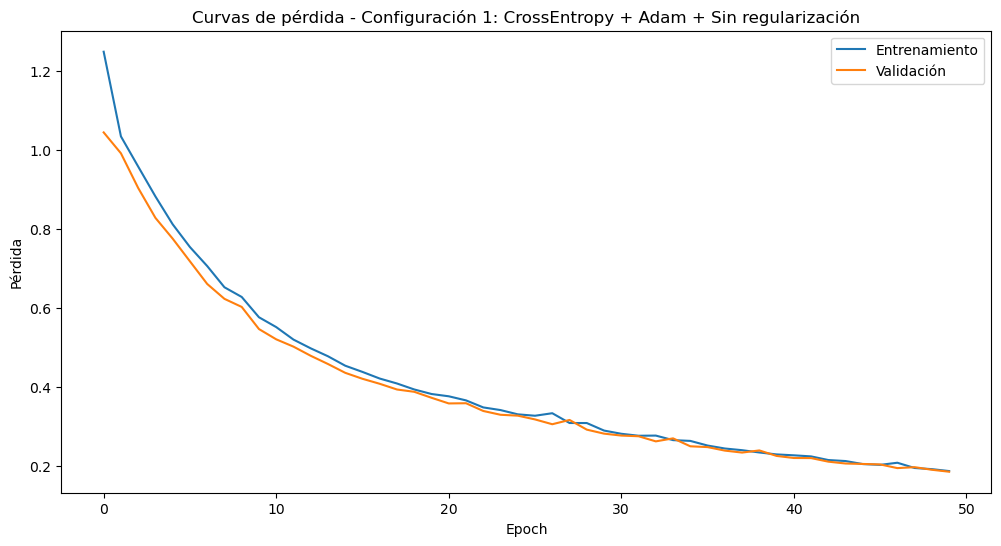

Epoch 1/50, Pérdida de entrenamiento: 1.0269, Pérdida de validación: 0.9514
Epoch 2/50, Pérdida de entrenamiento: 0.9024, Pérdida de validación: 0.8408
Epoch 3/50, Pérdida de entrenamiento: 0.8129, Pérdida de validación: 0.7540
Epoch 4/50, Pérdida de entrenamiento: 0.7360, Pérdida de validación: 0.6912
Epoch 5/50, Pérdida de entrenamiento: 0.6810, Pérdida de validación: 0.6653
Epoch 6/50, Pérdida de entrenamiento: 0.6391, Pérdida de validación: 0.5990
Epoch 7/50, Pérdida de entrenamiento: 0.5959, Pérdida de validación: 0.5624
Epoch 8/50, Pérdida de entrenamiento: 0.5619, Pérdida de validación: 0.5439
Epoch 9/50, Pérdida de entrenamiento: 0.5313, Pérdida de validación: 0.5134
Epoch 10/50, Pérdida de entrenamiento: 0.5065, Pérdida de validación: 0.4897
Epoch 11/50, Pérdida de entrenamiento: 0.4858, Pérdida de validación: 0.4693
Epoch 12/50, Pérdida de entrenamiento: 0.4669, Pérdida de validación: 0.4529
Epoch 13/50, Pérdida de entrenamiento: 0.4432, Pérdida de validación: 0.4259
Epoch 14

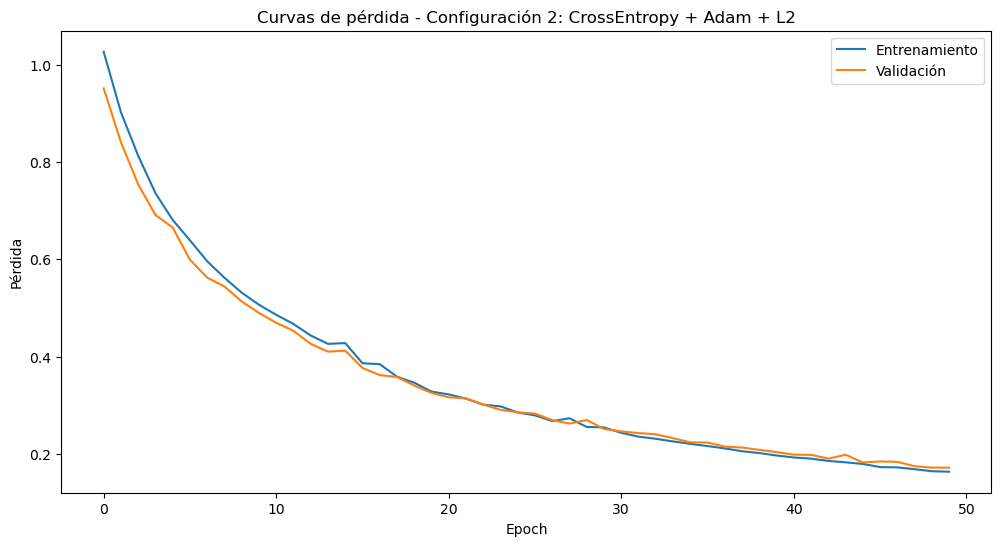

Regularización L1: Aumento de la pérdida por 0.0136
Regularización L1: Aumento de la pérdida por 0.0136
Regularización L1: Aumento de la pérdida por 0.0136
Regularización L1: Aumento de la pérdida por 0.0136
Regularización L1: Aumento de la pérdida por 0.0136
Regularización L1: Aumento de la pérdida por 0.0136
Regularización L1: Aumento de la pérdida por 0.0136
Regularización L1: Aumento de la pérdida por 0.0136
Epoch 1/50, Pérdida de entrenamiento: 1.2932, Pérdida de validación: 1.1285
Regularización L1: Aumento de la pérdida por 0.0135
Regularización L1: Aumento de la pérdida por 0.0135
Regularización L1: Aumento de la pérdida por 0.0135
Regularización L1: Aumento de la pérdida por 0.0135
Regularización L1: Aumento de la pérdida por 0.0135
Regularización L1: Aumento de la pérdida por 0.0135
Regularización L1: Aumento de la pérdida por 0.0135
Regularización L1: Aumento de la pérdida por 0.0135
Epoch 2/50, Pérdida de entrenamiento: 1.1031, Pérdida de validación: 1.0314
Regularización L

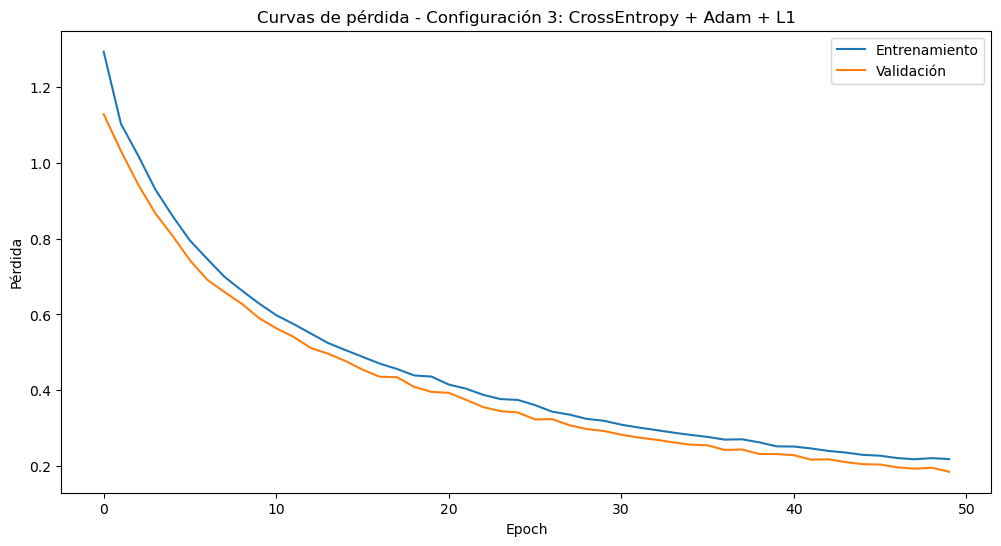

Epoch 1/50, Pérdida de entrenamiento: 1.2252, Pérdida de validación: 0.9714
Epoch 2/50, Pérdida de entrenamiento: 0.9884, Pérdida de validación: 0.8574
Epoch 3/50, Pérdida de entrenamiento: 0.8553, Pérdida de validación: 0.7733
Epoch 4/50, Pérdida de entrenamiento: 0.8190, Pérdida de validación: 0.7344
Epoch 5/50, Pérdida de entrenamiento: 0.7240, Pérdida de validación: 0.7429
Epoch 6/50, Pérdida de entrenamiento: 0.6718, Pérdida de validación: 0.7204
Epoch 7/50, Pérdida de entrenamiento: 0.6824, Pérdida de validación: 0.6177
Epoch 8/50, Pérdida de entrenamiento: 0.5959, Pérdida de validación: 0.6560
Epoch 9/50, Pérdida de entrenamiento: 0.6709, Pérdida de validación: 0.6278
Epoch 10/50, Pérdida de entrenamiento: 0.5524, Pérdida de validación: 0.5333
Epoch 11/50, Pérdida de entrenamiento: 0.5738, Pérdida de validación: 0.5697
Epoch 12/50, Pérdida de entrenamiento: 0.5648, Pérdida de validación: 0.4954
Epoch 13/50, Pérdida de entrenamiento: 0.5011, Pérdida de validación: 0.5132
Epoch 14

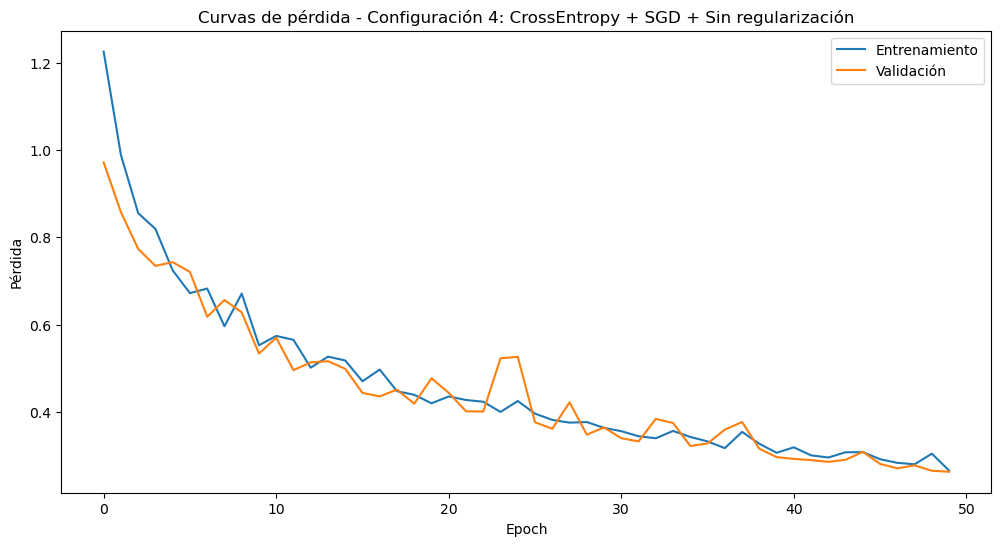

Epoch 1/50, Pérdida de entrenamiento: 1.2000, Pérdida de validación: 1.0878
Epoch 2/50, Pérdida de entrenamiento: 1.0699, Pérdida de validación: 0.9901
Epoch 3/50, Pérdida de entrenamiento: 0.9668, Pérdida de validación: 0.9495
Epoch 4/50, Pérdida de entrenamiento: 0.8830, Pérdida de validación: 0.8642
Epoch 5/50, Pérdida de entrenamiento: 0.8024, Pérdida de validación: 0.7472
Epoch 6/50, Pérdida de entrenamiento: 0.7549, Pérdida de validación: 0.7354
Epoch 7/50, Pérdida de entrenamiento: 0.7522, Pérdida de validación: 0.6880
Epoch 8/50, Pérdida de entrenamiento: 0.6617, Pérdida de validación: 0.6961
Epoch 9/50, Pérdida de entrenamiento: 0.6324, Pérdida de validación: 0.6000
Epoch 10/50, Pérdida de entrenamiento: 0.6006, Pérdida de validación: 0.6550
Epoch 11/50, Pérdida de entrenamiento: 0.5836, Pérdida de validación: 0.6573
Epoch 12/50, Pérdida de entrenamiento: 0.5923, Pérdida de validación: 0.5280
Epoch 13/50, Pérdida de entrenamiento: 0.5591, Pérdida de validación: 0.5361
Epoch 14

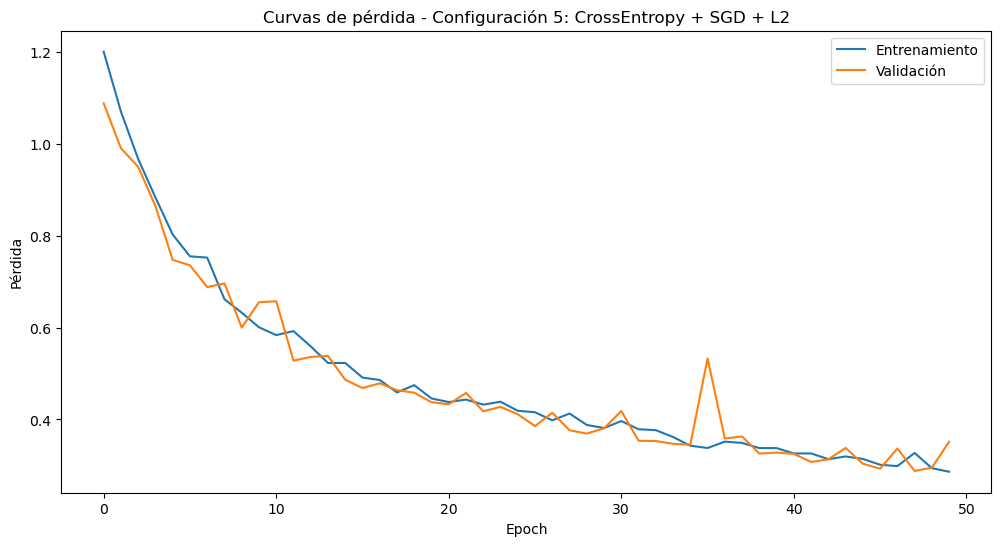

Regularización L1: Aumento de la pérdida por 0.0139
Regularización L1: Aumento de la pérdida por 0.0139
Regularización L1: Aumento de la pérdida por 0.0139
Regularización L1: Aumento de la pérdida por 0.0139
Regularización L1: Aumento de la pérdida por 0.0139
Regularización L1: Aumento de la pérdida por 0.0139
Regularización L1: Aumento de la pérdida por 0.0139
Regularización L1: Aumento de la pérdida por 0.0139
Epoch 1/50, Pérdida de entrenamiento: 0.9700, Pérdida de validación: 0.8356
Regularización L1: Aumento de la pérdida por 0.0139
Regularización L1: Aumento de la pérdida por 0.0139
Regularización L1: Aumento de la pérdida por 0.0139
Regularización L1: Aumento de la pérdida por 0.0139
Regularización L1: Aumento de la pérdida por 0.0139
Regularización L1: Aumento de la pérdida por 0.0139
Regularización L1: Aumento de la pérdida por 0.0139
Regularización L1: Aumento de la pérdida por 0.0139
Epoch 2/50, Pérdida de entrenamiento: 0.8132, Pérdida de validación: 0.7647
Regularización L

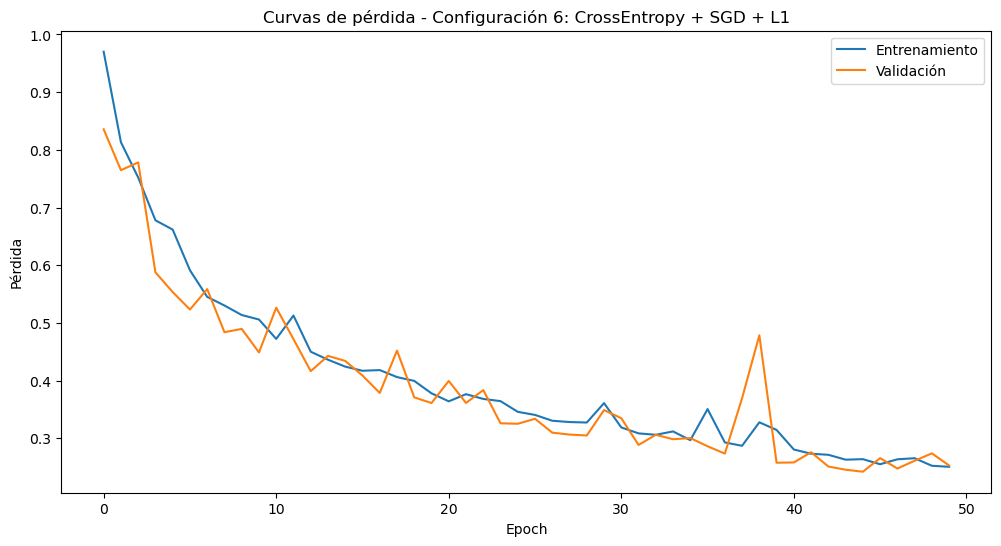

Epoch 1/50, Pérdida de entrenamiento: 1.5299, Pérdida de validación: 1.0014
Epoch 2/50, Pérdida de entrenamiento: 1.1713, Pérdida de validación: 0.8423
Epoch 3/50, Pérdida de entrenamiento: 0.9394, Pérdida de validación: 0.6611
Epoch 4/50, Pérdida de entrenamiento: 0.8617, Pérdida de validación: 0.6739
Epoch 5/50, Pérdida de entrenamiento: 0.8576, Pérdida de validación: 0.7703
Epoch 6/50, Pérdida de entrenamiento: 0.9927, Pérdida de validación: 1.3644
Epoch 7/50, Pérdida de entrenamiento: 0.8206, Pérdida de validación: 0.6426
Epoch 8/50, Pérdida de entrenamiento: 0.6564, Pérdida de validación: 0.5068
Epoch 9/50, Pérdida de entrenamiento: 0.6451, Pérdida de validación: 0.5128
Epoch 10/50, Pérdida de entrenamiento: 0.7079, Pérdida de validación: 0.4793
Epoch 11/50, Pérdida de entrenamiento: 0.6785, Pérdida de validación: 0.4662
Epoch 12/50, Pérdida de entrenamiento: 0.6646, Pérdida de validación: 0.4806
Epoch 13/50, Pérdida de entrenamiento: 0.6830, Pérdida de validación: 0.4631
Epoch 14

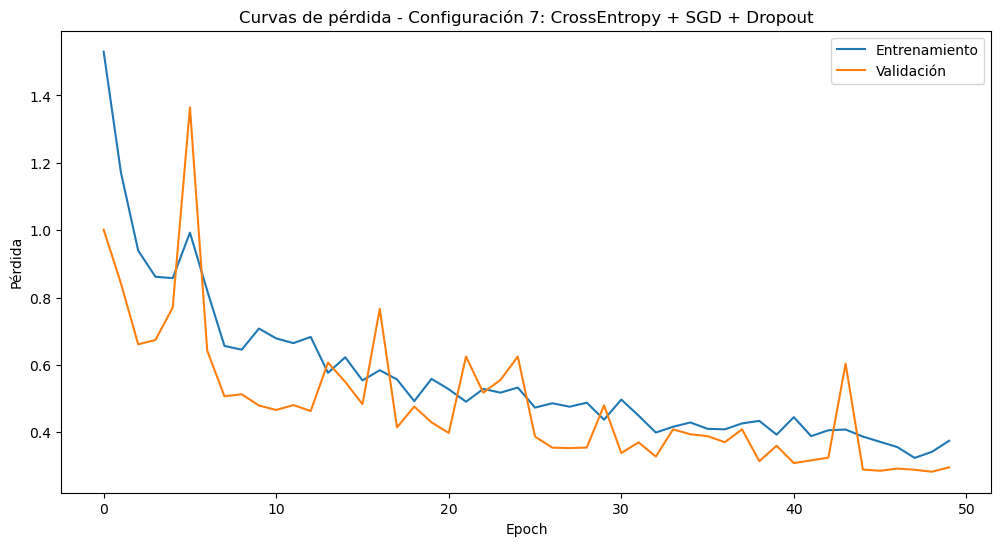

Epoch 1/50, Pérdida de entrenamiento: 1.2348, Pérdida de validación: 0.9198
Epoch 2/50, Pérdida de entrenamiento: 1.1465, Pérdida de validación: 0.8385
Epoch 3/50, Pérdida de entrenamiento: 0.9458, Pérdida de validación: 0.7667
Epoch 4/50, Pérdida de entrenamiento: 0.9548, Pérdida de validación: 0.7250
Epoch 5/50, Pérdida de entrenamiento: 0.8790, Pérdida de validación: 0.6784
Epoch 6/50, Pérdida de entrenamiento: 0.7675, Pérdida de validación: 0.6328
Epoch 7/50, Pérdida de entrenamiento: 0.7907, Pérdida de validación: 0.5984
Epoch 8/50, Pérdida de entrenamiento: 0.7027, Pérdida de validación: 0.5737
Epoch 9/50, Pérdida de entrenamiento: 0.6872, Pérdida de validación: 0.5475
Epoch 10/50, Pérdida de entrenamiento: 0.5970, Pérdida de validación: 0.5253
Epoch 11/50, Pérdida de entrenamiento: 0.6024, Pérdida de validación: 0.5084
Epoch 12/50, Pérdida de entrenamiento: 0.6044, Pérdida de validación: 0.4769
Epoch 13/50, Pérdida de entrenamiento: 0.5598, Pérdida de validación: 0.4628
Epoch 14

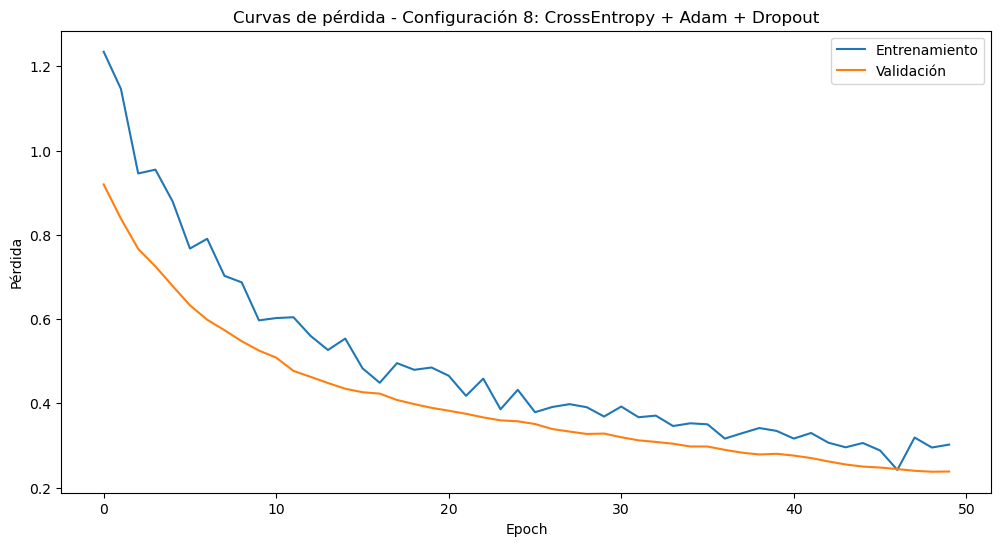

Regularización L1: Aumento de la pérdida por 0.0140
Regularización L1: Aumento de la pérdida por 0.0140
Regularización L1: Aumento de la pérdida por 0.0140
Regularización L1: Aumento de la pérdida por 0.0140
Regularización L1: Aumento de la pérdida por 0.0140
Regularización L1: Aumento de la pérdida por 0.0140
Regularización L1: Aumento de la pérdida por 0.0140
Regularización L1: Aumento de la pérdida por 0.0140
Epoch 1/50, Pérdida de entrenamiento: 1.2992, Pérdida de validación: 0.9305
Regularización L1: Aumento de la pérdida por 0.0140
Regularización L1: Aumento de la pérdida por 0.0140
Regularización L1: Aumento de la pérdida por 0.0140
Regularización L1: Aumento de la pérdida por 0.0139
Regularización L1: Aumento de la pérdida por 0.0139
Regularización L1: Aumento de la pérdida por 0.0139
Regularización L1: Aumento de la pérdida por 0.0139
Regularización L1: Aumento de la pérdida por 0.0139
Epoch 2/50, Pérdida de entrenamiento: 1.0731, Pérdida de validación: 0.8590
Regularización L

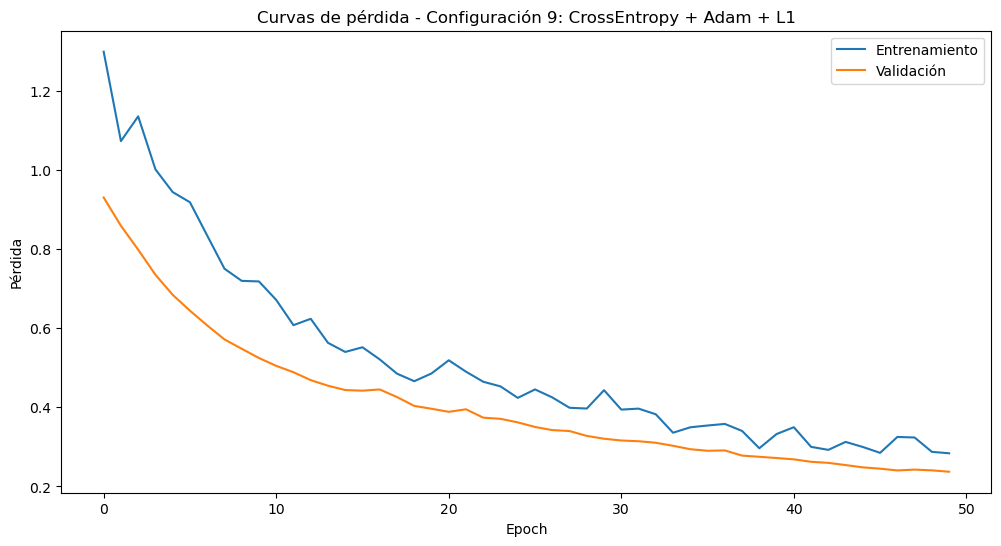

Epoch 1/50, Pérdida de entrenamiento: 0.9954, Pérdida de validación: 1.2522
Epoch 2/50, Pérdida de entrenamiento: 0.8946, Pérdida de validación: 0.6924
Epoch 3/50, Pérdida de entrenamiento: 0.6770, Pérdida de validación: 0.6345
Epoch 4/50, Pérdida de entrenamiento: 0.6443, Pérdida de validación: 0.6318
Epoch 5/50, Pérdida de entrenamiento: 0.6150, Pérdida de validación: 0.5295
Epoch 6/50, Pérdida de entrenamiento: 0.6020, Pérdida de validación: 0.5455
Epoch 7/50, Pérdida de entrenamiento: 0.5283, Pérdida de validación: 0.4768
Epoch 8/50, Pérdida de entrenamiento: 0.4762, Pérdida de validación: 0.5168
Epoch 9/50, Pérdida de entrenamiento: 0.5274, Pérdida de validación: 0.4533
Epoch 10/50, Pérdida de entrenamiento: 0.4663, Pérdida de validación: 0.4239
Epoch 11/50, Pérdida de entrenamiento: 0.4162, Pérdida de validación: 0.4699
Epoch 12/50, Pérdida de entrenamiento: 0.4393, Pérdida de validación: 0.5203
Epoch 13/50, Pérdida de entrenamiento: 0.4359, Pérdida de validación: 0.4468
Epoch 14

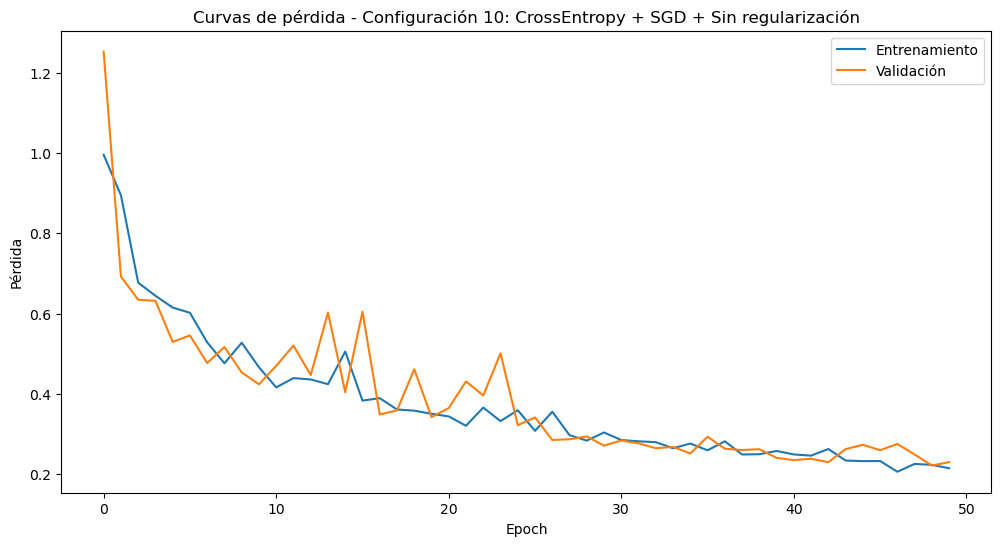

Regularización L1: Aumento de la pérdida por 0.0138
Regularización L1: Aumento de la pérdida por 0.0138
Regularización L1: Aumento de la pérdida por 0.0138
Regularización L1: Aumento de la pérdida por 0.0138
Regularización L1: Aumento de la pérdida por 0.0138
Regularización L1: Aumento de la pérdida por 0.0138
Regularización L1: Aumento de la pérdida por 0.0138
Regularización L1: Aumento de la pérdida por 0.0138
Epoch 1/50, Pérdida de entrenamiento: 0.9960, Pérdida de validación: 0.8390
Regularización L1: Aumento de la pérdida por 0.0138
Regularización L1: Aumento de la pérdida por 0.0138
Regularización L1: Aumento de la pérdida por 0.0138
Regularización L1: Aumento de la pérdida por 0.0138
Regularización L1: Aumento de la pérdida por 0.0138
Regularización L1: Aumento de la pérdida por 0.0138
Regularización L1: Aumento de la pérdida por 0.0138
Regularización L1: Aumento de la pérdida por 0.0138
Epoch 2/50, Pérdida de entrenamiento: 0.8327, Pérdida de validación: 0.7276
Regularización L

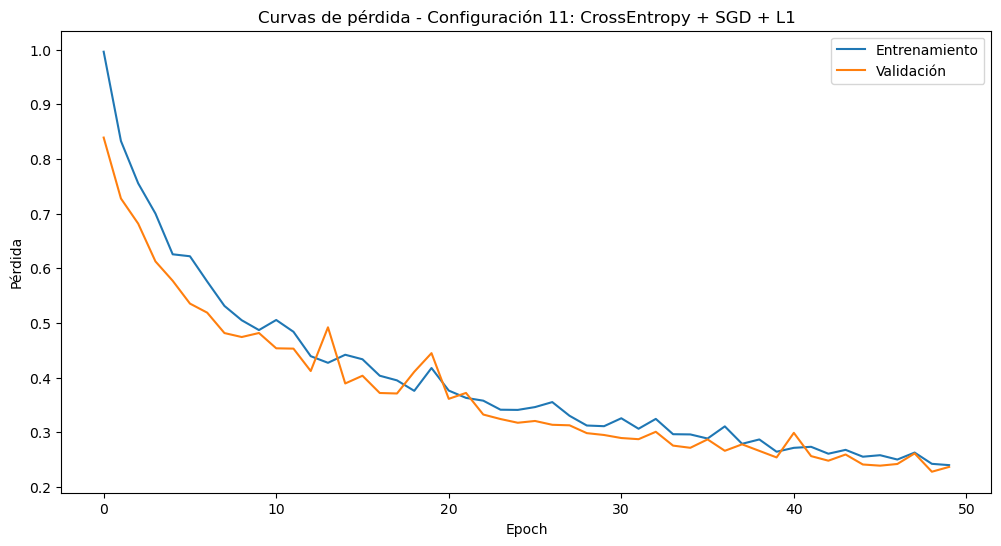

Epoch 1/50, Pérdida de entrenamiento: 1.1118, Pérdida de validación: 0.8950
Epoch 2/50, Pérdida de entrenamiento: 0.9730, Pérdida de validación: 0.7614
Epoch 3/50, Pérdida de entrenamiento: 0.8803, Pérdida de validación: 0.6710
Epoch 4/50, Pérdida de entrenamiento: 0.7210, Pérdida de validación: 0.6520
Epoch 5/50, Pérdida de entrenamiento: 0.6745, Pérdida de validación: 0.6194
Epoch 6/50, Pérdida de entrenamiento: 0.6029, Pérdida de validación: 0.6569
Epoch 7/50, Pérdida de entrenamiento: 0.5852, Pérdida de validación: 0.7022
Epoch 8/50, Pérdida de entrenamiento: 0.5647, Pérdida de validación: 0.5234
Epoch 9/50, Pérdida de entrenamiento: 0.5434, Pérdida de validación: 0.5816
Epoch 10/50, Pérdida de entrenamiento: 0.7412, Pérdida de validación: 0.5432
Epoch 11/50, Pérdida de entrenamiento: 0.5090, Pérdida de validación: 0.4683
Epoch 12/50, Pérdida de entrenamiento: 0.5075, Pérdida de validación: 0.6691
Epoch 13/50, Pérdida de entrenamiento: 0.5382, Pérdida de validación: 0.4420
Epoch 14

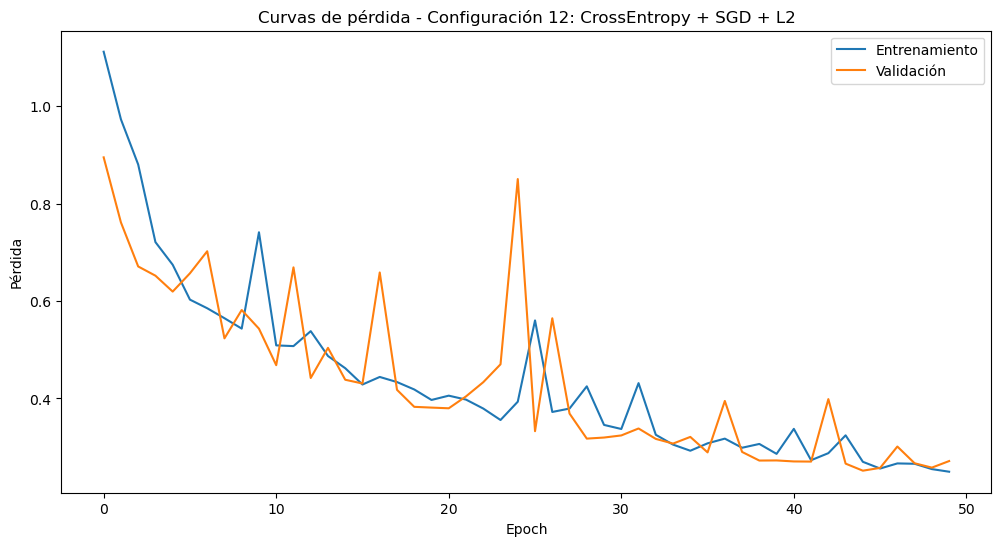

Epoch 1/50, Pérdida de entrenamiento: 1.4516, Pérdida de validación: 1.0721
Epoch 2/50, Pérdida de entrenamiento: 1.1490, Pérdida de validación: 0.9319
Epoch 3/50, Pérdida de entrenamiento: 1.0387, Pérdida de validación: 0.8295
Epoch 4/50, Pérdida de entrenamiento: 0.9097, Pérdida de validación: 0.7691
Epoch 5/50, Pérdida de entrenamiento: 0.8818, Pérdida de validación: 0.7673
Epoch 6/50, Pérdida de entrenamiento: 0.7530, Pérdida de validación: 0.6880
Epoch 7/50, Pérdida de entrenamiento: 0.7461, Pérdida de validación: 0.6322
Epoch 8/50, Pérdida de entrenamiento: 0.7284, Pérdida de validación: 0.6013
Epoch 9/50, Pérdida de entrenamiento: 0.6893, Pérdida de validación: 0.5830
Epoch 10/50, Pérdida de entrenamiento: 0.6913, Pérdida de validación: 0.5606
Epoch 11/50, Pérdida de entrenamiento: 0.6452, Pérdida de validación: 0.5466
Epoch 12/50, Pérdida de entrenamiento: 0.6045, Pérdida de validación: 0.5280
Epoch 13/50, Pérdida de entrenamiento: 0.6928, Pérdida de validación: 0.6292
Epoch 14

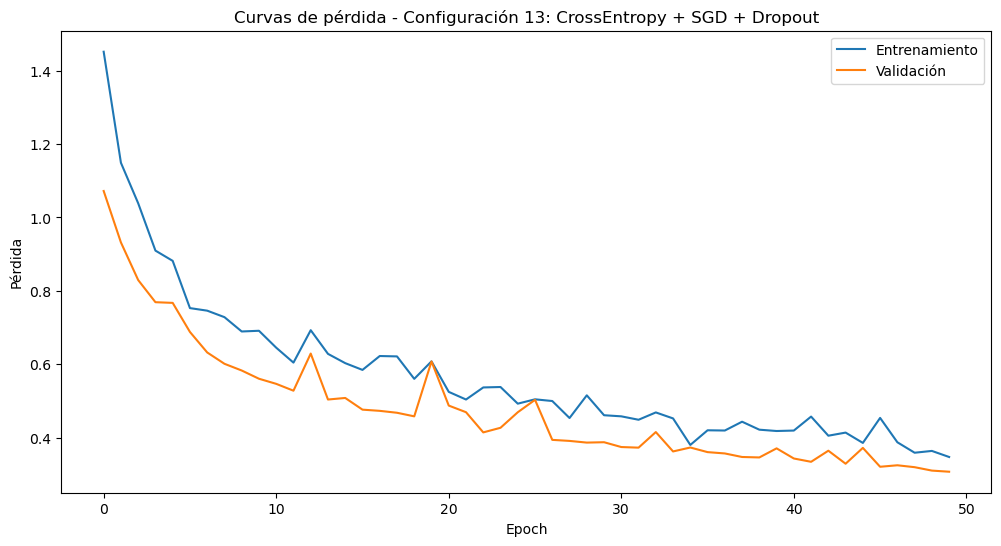

Epoch 1/50, Pérdida de entrenamiento: 1.0499, Pérdida de validación: 0.9685
Epoch 2/50, Pérdida de entrenamiento: 0.9388, Pérdida de validación: 0.8892
Epoch 3/50, Pérdida de entrenamiento: 0.8741, Pérdida de validación: 0.8139
Epoch 4/50, Pérdida de entrenamiento: 0.8034, Pérdida de validación: 0.7670
Epoch 5/50, Pérdida de entrenamiento: 0.7478, Pérdida de validación: 0.7042
Epoch 6/50, Pérdida de entrenamiento: 0.6982, Pérdida de validación: 0.6543
Epoch 7/50, Pérdida de entrenamiento: 0.6519, Pérdida de validación: 0.6144
Epoch 8/50, Pérdida de entrenamiento: 0.6105, Pérdida de validación: 0.5764
Epoch 9/50, Pérdida de entrenamiento: 0.5772, Pérdida de validación: 0.5495
Epoch 10/50, Pérdida de entrenamiento: 0.5461, Pérdida de validación: 0.5211
Epoch 11/50, Pérdida de entrenamiento: 0.5232, Pérdida de validación: 0.4999
Epoch 12/50, Pérdida de entrenamiento: 0.4987, Pérdida de validación: 0.4737
Epoch 13/50, Pérdida de entrenamiento: 0.4796, Pérdida de validación: 0.4611
Epoch 14

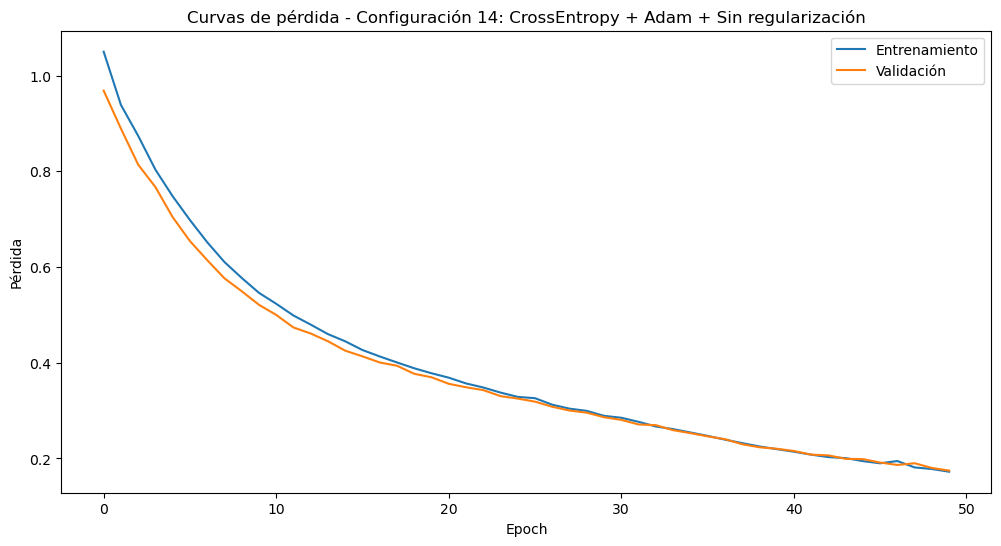

Regularización L1: Aumento de la pérdida por 0.0142
Regularización L1: Aumento de la pérdida por 0.0142
Regularización L1: Aumento de la pérdida por 0.0142
Regularización L1: Aumento de la pérdida por 0.0142
Regularización L1: Aumento de la pérdida por 0.0142
Regularización L1: Aumento de la pérdida por 0.0142
Regularización L1: Aumento de la pérdida por 0.0142
Regularización L1: Aumento de la pérdida por 0.0142
Epoch 1/50, Pérdida de entrenamiento: 1.1447, Pérdida de validación: 1.0601
Regularización L1: Aumento de la pérdida por 0.0141
Regularización L1: Aumento de la pérdida por 0.0141
Regularización L1: Aumento de la pérdida por 0.0141
Regularización L1: Aumento de la pérdida por 0.0141
Regularización L1: Aumento de la pérdida por 0.0141
Regularización L1: Aumento de la pérdida por 0.0141
Regularización L1: Aumento de la pérdida por 0.0141
Regularización L1: Aumento de la pérdida por 0.0141
Epoch 2/50, Pérdida de entrenamiento: 1.0213, Pérdida de validación: 0.9455
Regularización L

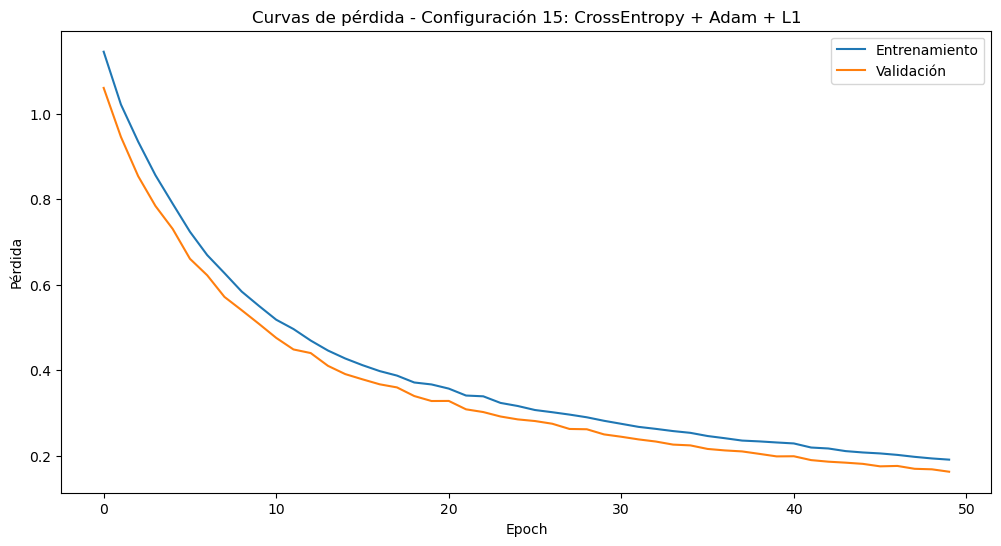

Epoch 1/50, Pérdida de entrenamiento: 0.9586, Pérdida de validación: 0.8688
Epoch 2/50, Pérdida de entrenamiento: 0.8531, Pérdida de validación: 0.7903
Epoch 3/50, Pérdida de entrenamiento: 0.7707, Pérdida de validación: 0.7206
Epoch 4/50, Pérdida de entrenamiento: 0.6981, Pérdida de validación: 0.6484
Epoch 5/50, Pérdida de entrenamiento: 0.6351, Pérdida de validación: 0.5860
Epoch 6/50, Pérdida de entrenamiento: 0.5791, Pérdida de validación: 0.5410
Epoch 7/50, Pérdida de entrenamiento: 0.5311, Pérdida de validación: 0.4972
Epoch 8/50, Pérdida de entrenamiento: 0.4940, Pérdida de validación: 0.4733
Epoch 9/50, Pérdida de entrenamiento: 0.4622, Pérdida de validación: 0.4345
Epoch 10/50, Pérdida de entrenamiento: 0.4423, Pérdida de validación: 0.4123
Epoch 11/50, Pérdida de entrenamiento: 0.4112, Pérdida de validación: 0.3984
Epoch 12/50, Pérdida de entrenamiento: 0.3934, Pérdida de validación: 0.3808
Epoch 13/50, Pérdida de entrenamiento: 0.3774, Pérdida de validación: 0.3605
Epoch 14

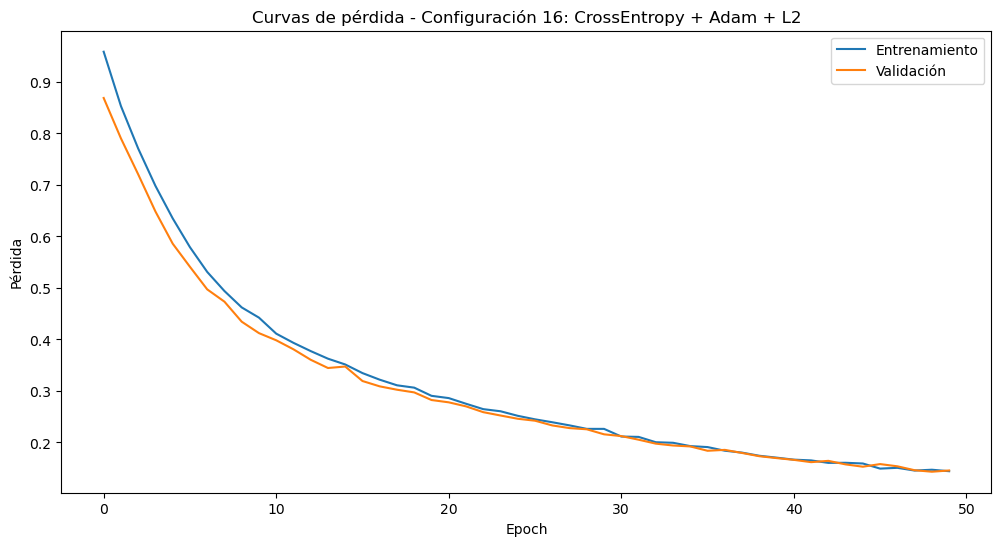

Epoch 1/50, Pérdida de entrenamiento: 1.2652, Pérdida de validación: 0.9928
Epoch 2/50, Pérdida de entrenamiento: 1.2064, Pérdida de validación: 0.9157
Epoch 3/50, Pérdida de entrenamiento: 1.1920, Pérdida de validación: 0.8566
Epoch 4/50, Pérdida de entrenamiento: 1.1617, Pérdida de validación: 0.8069
Epoch 5/50, Pérdida de entrenamiento: 1.0266, Pérdida de validación: 0.7639
Epoch 6/50, Pérdida de entrenamiento: 0.9276, Pérdida de validación: 0.7155
Epoch 7/50, Pérdida de entrenamiento: 0.8684, Pérdida de validación: 0.6693
Epoch 8/50, Pérdida de entrenamiento: 0.8228, Pérdida de validación: 0.6279
Epoch 9/50, Pérdida de entrenamiento: 0.7885, Pérdida de validación: 0.5991
Epoch 10/50, Pérdida de entrenamiento: 0.7292, Pérdida de validación: 0.5801
Epoch 11/50, Pérdida de entrenamiento: 0.7046, Pérdida de validación: 0.5445
Epoch 12/50, Pérdida de entrenamiento: 0.6737, Pérdida de validación: 0.5202
Epoch 13/50, Pérdida de entrenamiento: 0.6324, Pérdida de validación: 0.4950
Epoch 14

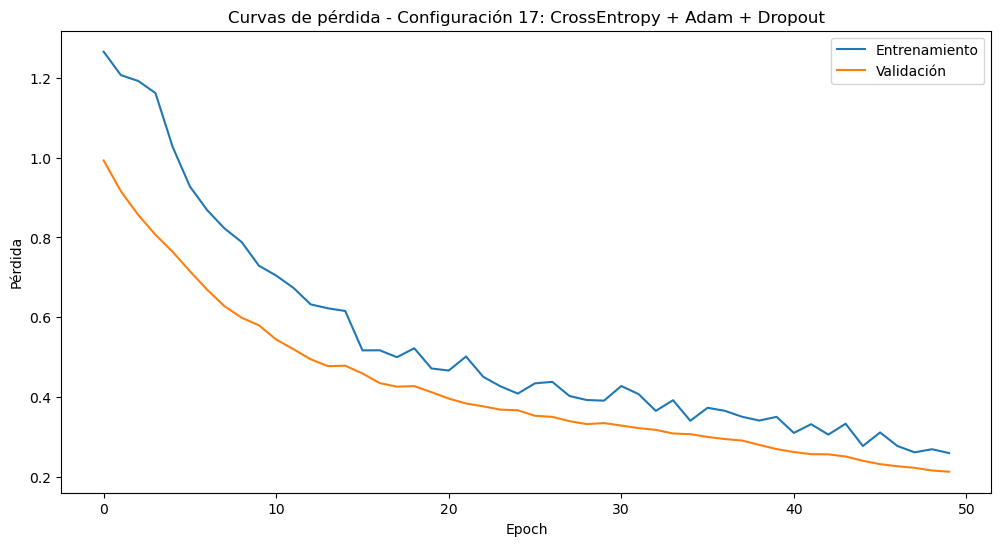

Epoch 1/50, Pérdida de entrenamiento: -5.0068, Pérdida de validación: -11.3501
Epoch 2/50, Pérdida de entrenamiento: -16.2479, Pérdida de validación: -26.6831
Epoch 3/50, Pérdida de entrenamiento: -35.5313, Pérdida de validación: -55.2858
Epoch 4/50, Pérdida de entrenamiento: -72.6459, Pérdida de validación: -111.9295
Epoch 5/50, Pérdida de entrenamiento: -146.5831, Pérdida de validación: -225.2297
Epoch 6/50, Pérdida de entrenamiento: -295.5646, Pérdida de validación: -452.2117
Epoch 7/50, Pérdida de entrenamiento: -594.5349, Pérdida de validación: -922.8477
Epoch 8/50, Pérdida de entrenamiento: -1209.7387, Pérdida de validación: -1855.3062
Epoch 9/50, Pérdida de entrenamiento: -2435.6397, Pérdida de validación: -3775.4142
Epoch 10/50, Pérdida de entrenamiento: -4948.4450, Pérdida de validación: -7673.3713
Epoch 11/50, Pérdida de entrenamiento: -10034.9630, Pérdida de validación: -15589.8684
Epoch 12/50, Pérdida de entrenamiento: -20341.3922, Pérdida de validación: -31506.2687
Epoch 1

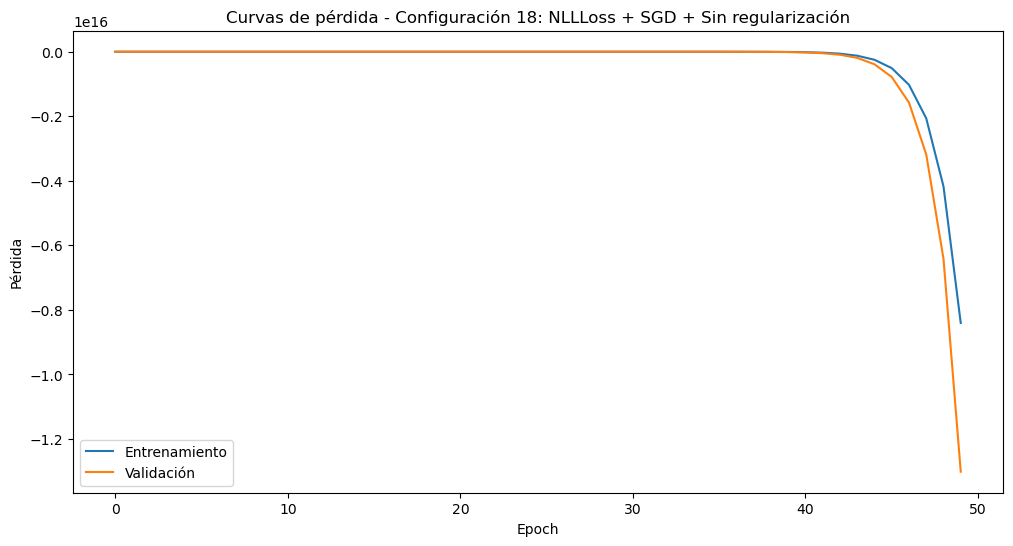

Regularización L1: Aumento de la pérdida por 0.0138
Regularización L1: Aumento de la pérdida por 0.0138
Regularización L1: Aumento de la pérdida por 0.0139
Regularización L1: Aumento de la pérdida por 0.0139
Regularización L1: Aumento de la pérdida por 0.0139
Regularización L1: Aumento de la pérdida por 0.0140
Regularización L1: Aumento de la pérdida por 0.0140
Regularización L1: Aumento de la pérdida por 0.0141
Epoch 1/50, Pérdida de entrenamiento: -3.0999, Pérdida de validación: -7.6805
Regularización L1: Aumento de la pérdida por 0.0142
Regularización L1: Aumento de la pérdida por 0.0143
Regularización L1: Aumento de la pérdida por 0.0144
Regularización L1: Aumento de la pérdida por 0.0145
Regularización L1: Aumento de la pérdida por 0.0146
Regularización L1: Aumento de la pérdida por 0.0147
Regularización L1: Aumento de la pérdida por 0.0148
Regularización L1: Aumento de la pérdida por 0.0149
Epoch 2/50, Pérdida de entrenamiento: -11.0635, Pérdida de validación: -18.5916
Regulariza

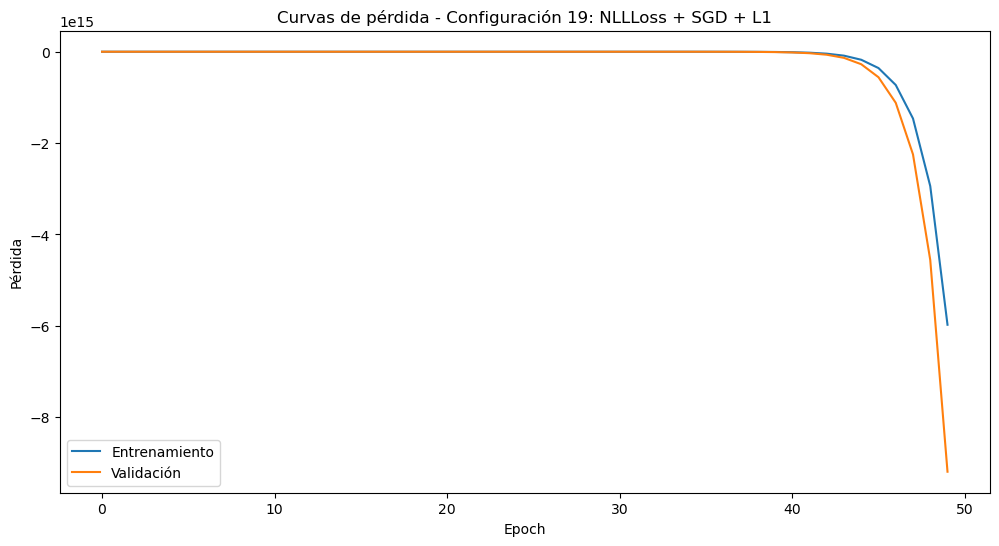

Epoch 1/50, Pérdida de entrenamiento: -2.7695, Pérdida de validación: -7.7767
Epoch 2/50, Pérdida de entrenamiento: -11.6344, Pérdida de validación: -19.3997
Epoch 3/50, Pérdida de entrenamiento: -26.0935, Pérdida de validación: -40.7723
Epoch 4/50, Pérdida de entrenamiento: -53.7295, Pérdida de validación: -83.1916
Epoch 5/50, Pérdida de entrenamiento: -109.0354, Pérdida de validación: -167.0914
Epoch 6/50, Pérdida de entrenamiento: -219.8103, Pérdida de validación: -340.0633
Epoch 7/50, Pérdida de entrenamiento: -446.6248, Pérdida de validación: -686.3378
Epoch 8/50, Pérdida de entrenamiento: -900.3599, Pérdida de validación: -1391.0978
Epoch 9/50, Pérdida de entrenamiento: -1822.8740, Pérdida de validación: -2818.0046
Epoch 10/50, Pérdida de entrenamiento: -3693.9610, Pérdida de validación: -5693.7554
Epoch 11/50, Pérdida de entrenamiento: -7463.3374, Pérdida de validación: -11588.9144
Epoch 12/50, Pérdida de entrenamiento: -15160.8056, Pérdida de validación: -23427.8033
Epoch 13/50

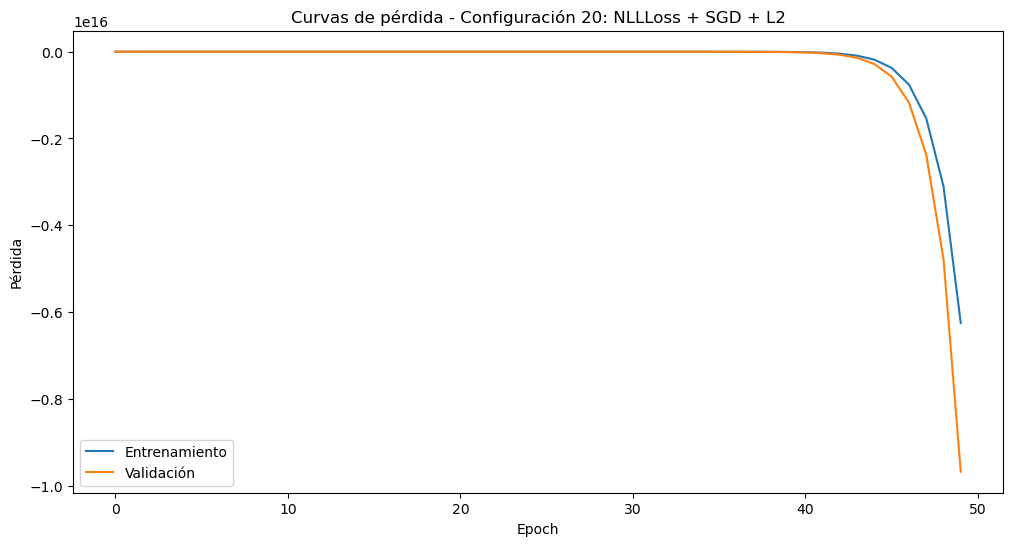

Epoch 1/50, Pérdida de entrenamiento: -2.7001, Pérdida de validación: -6.9698
Epoch 2/50, Pérdida de entrenamiento: -10.4418, Pérdida de validación: -17.2759
Epoch 3/50, Pérdida de entrenamiento: -23.2646, Pérdida de validación: -36.6408
Epoch 4/50, Pérdida de entrenamiento: -51.2227, Pérdida de validación: -77.5768
Epoch 5/50, Pérdida de entrenamiento: -105.5070, Pérdida de validación: -158.4599
Epoch 6/50, Pérdida de entrenamiento: -206.4963, Pérdida de validación: -323.8903
Epoch 7/50, Pérdida de entrenamiento: -415.3084, Pérdida de validación: -648.1911
Epoch 8/50, Pérdida de entrenamiento: -835.2389, Pérdida de validación: -1306.3045
Epoch 9/50, Pérdida de entrenamiento: -1791.9957, Pérdida de validación: -2707.4342
Epoch 10/50, Pérdida de entrenamiento: -3566.6387, Pérdida de validación: -5555.0324
Epoch 11/50, Pérdida de entrenamiento: -7152.1141, Pérdida de validación: -11171.3482
Epoch 12/50, Pérdida de entrenamiento: -14352.6530, Pérdida de validación: -22538.1992
Epoch 13/50

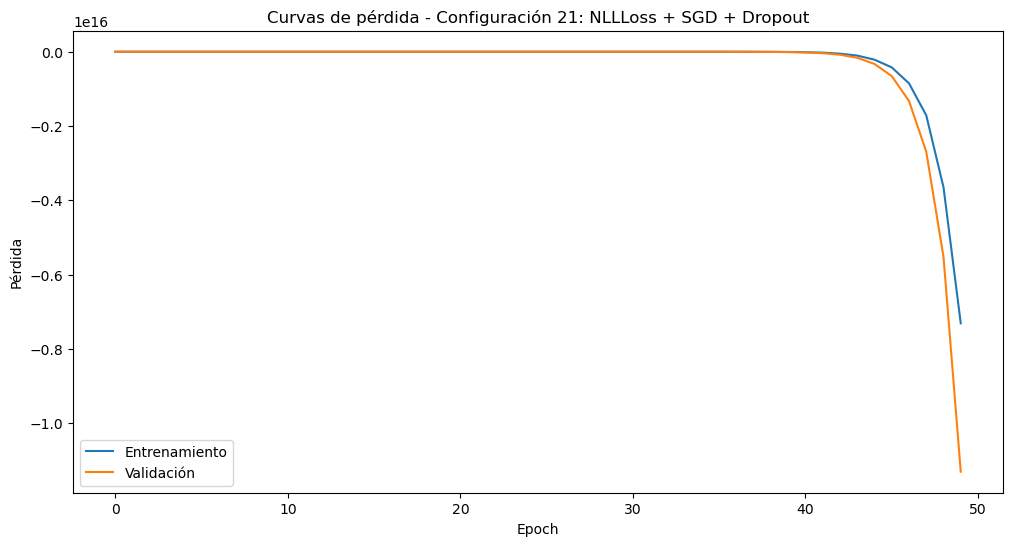

{'Configuración': 1, 'Función de pérdida': 'CrossEntropy', 'Optimizador': 'Adam', 'Tasa de aprendizaje': 0.001, 'Decaimiento de peso (L2)': 0, 'Lambda L1': 0, 'Probabilidad de Dropout': 0, 'Precisión': 0.3, 'F1 Score': 0.13846153846153844, 'Tiempo de entrenamiento (s)': 0.32284998893737793}
{'Configuración': 2, 'Función de pérdida': 'CrossEntropy', 'Optimizador': 'Adam', 'Tasa de aprendizaje': 0.001, 'Decaimiento de peso (L2)': 0.0001, 'Lambda L1': 0, 'Probabilidad de Dropout': 0, 'Precisión': 0.36666666666666664, 'F1 Score': 0.19674796747967477, 'Tiempo de entrenamiento (s)': 0.1847689151763916}
{'Configuración': 3, 'Función de pérdida': 'CrossEntropy', 'Optimizador': 'Adam', 'Tasa de aprendizaje': 0.001, 'Decaimiento de peso (L2)': 0, 'Lambda L1': 0.0001, 'Probabilidad de Dropout': 0, 'Precisión': 0.3, 'F1 Score': 0.13846153846153844, 'Tiempo de entrenamiento (s)': 0.2161550521850586}
{'Configuración': 4, 'Función de pérdida': 'CrossEntropy', 'Optimizador': 'SGD', 'Tasa de aprendizaj

In [24]:
from sklearn.metrics import accuracy_score, f1_score


def configure_and_train_model(loss_fn, optimizer_type, input_dim, hidden_dim, output_dim, train_loader, val_loader, epochs, lr, weight_decay=0, l1_lambda=0, dropout_p=0):
    model = ModifiedNN(input_dim, hidden_dim, output_dim, dropout_p=dropout_p)
    
    if optimizer_type == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_type == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError('Tipo de optimizador no reconocido')
    
    if loss_fn == 'CrossEntropy':
        criterion = torch.nn.CrossEntropyLoss()
    elif loss_fn == 'NLLLoss':
        criterion = torch.nn.NLLLoss()
    else:
        raise ValueError('Función de pérdida no reconocida')
    
    return train_modified_nn(model, criterion, optimizer, train_loader, val_loader, epochs, l1_lambda)

optimization_configs = [
    {'loss_fn': 'CrossEntropy', 'optimizer_type': 'Adam', 'lr': 0.001, 'weight_decay': 0, 'l1_lambda': 0, 'dropout_p': 0},
    {'loss_fn': 'CrossEntropy', 'optimizer_type': 'Adam', 'lr': 0.001, 'weight_decay': 0.0001, 'l1_lambda': 0, 'dropout_p': 0},
    {'loss_fn': 'CrossEntropy', 'optimizer_type': 'Adam', 'lr': 0.001, 'weight_decay': 0, 'l1_lambda': 0.0001, 'dropout_p': 0},
    {'loss_fn': 'CrossEntropy', 'optimizer_type': 'SGD', 'lr': 0.01, 'weight_decay': 0, 'l1_lambda': 0, 'dropout_p': 0},
    {'loss_fn': 'CrossEntropy', 'optimizer_type': 'SGD', 'lr': 0.01, 'weight_decay': 0.0001, 'l1_lambda': 0, 'dropout_p': 0},
    {'loss_fn': 'CrossEntropy', 'optimizer_type': 'SGD', 'lr': 0.01, 'weight_decay': 0, 'l1_lambda': 0.0001, 'dropout_p': 0},
    {'loss_fn': 'CrossEntropy', 'optimizer_type': 'SGD', 'lr': 0.01, 'weight_decay': 0, 'l1_lambda': 0, 'dropout_p': 0.5},
    {'loss_fn': 'CrossEntropy', 'optimizer_type': 'Adam', 'lr': 0.001, 'weight_decay': 0, 'l1_lambda': 0, 'dropout_p': 0.5},
    {'loss_fn': 'CrossEntropy', 'optimizer_type': 'Adam', 'lr': 0.001, 'weight_decay': 0.0001, 'l1_lambda': 0.0001, 'dropout_p': 0.5},
    {'loss_fn': 'CrossEntropy', 'optimizer_type': 'SGD', 'lr': 0.01, 'weight_decay': 0, 'l1_lambda': 0, 'dropout_p': 0},
    {'loss_fn': 'CrossEntropy', 'optimizer_type': 'SGD', 'lr': 0.01, 'weight_decay': 0, 'l1_lambda': 0.0001, 'dropout_p': 0},
    {'loss_fn': 'CrossEntropy', 'optimizer_type': 'SGD', 'lr': 0.01, 'weight_decay': 0.0001, 'l1_lambda': 0, 'dropout_p': 0},
    {'loss_fn': 'CrossEntropy', 'optimizer_type': 'SGD', 'lr': 0.01, 'weight_decay': 0, 'l1_lambda': 0, 'dropout_p': 0.5},
    {'loss_fn': 'CrossEntropy', 'optimizer_type': 'Adam', 'lr': 0.001, 'weight_decay': 0, 'l1_lambda': 0, 'dropout_p': 0},
    {'loss_fn': 'CrossEntropy', 'optimizer_type': 'Adam', 'lr': 0.001, 'weight_decay': 0, 'l1_lambda': 0.0001, 'dropout_p': 0},
    {'loss_fn': 'CrossEntropy', 'optimizer_type': 'Adam', 'lr': 0.001, 'weight_decay': 0.0001, 'l1_lambda': 0, 'dropout_p': 0},
    {'loss_fn': 'CrossEntropy', 'optimizer_type': 'Adam', 'lr': 0.001, 'weight_decay': 0, 'l1_lambda': 0, 'dropout_p': 0.5},
    {'loss_fn': 'NLLLoss', 'optimizer_type': 'SGD', 'lr': 0.01, 'weight_decay': 0, 'l1_lambda': 0, 'dropout_p': 0},
    {'loss_fn': 'NLLLoss', 'optimizer_type': 'SGD', 'lr': 0.01, 'weight_decay': 0, 'l1_lambda': 0.0001, 'dropout_p': 0},
    {'loss_fn': 'NLLLoss', 'optimizer_type': 'SGD', 'lr': 0.01, 'weight_decay': 0.0001, 'l1_lambda': 0, 'dropout_p': 0},
    {'loss_fn': 'NLLLoss', 'optimizer_type': 'SGD', 'lr': 0.01, 'weight_decay': 0, 'l1_lambda': 0, 'dropout_p': 0.5},
]


results = []

for i, config in enumerate(optimization_configs):
    loss_fn = config['loss_fn']
    optimizer_type = config['optimizer_type']
    lr = config['lr']
    weight_decay = config['weight_decay']
    l1_lambda = config['l1_lambda']
    dropout_p = config['dropout_p']
    
    start_time = time.time()
    train_losses, val_losses = configure_and_train_model(loss_fn, optimizer_type, input_dim, hidden_dim, output_dim, train_loader, val_loader, epochs, lr, weight_decay, l1_lambda, dropout_p)
    end_time = time.time()
    
    train_time = end_time - start_time
    
    # Cálculo de métricas
    model = ModifiedNN(input_dim, hidden_dim, output_dim, dropout_p=dropout_p)
    model.eval()
    with torch.no_grad():
        predictions = model(X_val_tensor)
    predictions = predictions.argmax(dim=1)
    accuracy = accuracy_score(y_val, predictions)
    f1 = f1_score(y_val, predictions, average='weighted')
    
    results.append({
        'Configuración': i + 1,
        'Función de pérdida': loss_fn,
        'Optimizador': optimizer_type,
        'Tasa de aprendizaje': lr,
        'Decaimiento de peso (L2)': weight_decay,
        'Lambda L1': l1_lambda,
        'Probabilidad de Dropout': dropout_p,
        'Precisión': accuracy,
        'F1 Score': f1,
        'Tiempo de entrenamiento (s)': train_time,
    })
    
    # Visualización
    plt.figure(figsize=(12, 6))
    plt.plot(train_losses, label='Entrenamiento')
    plt.plot(val_losses, label='Validación')
    plt.title(f'Curvas de pérdida - Configuración {i + 1}: {loss_fn} + {optimizer_type} + {"L1" if l1_lambda > 0 else "L2" if weight_decay > 0 else "Dropout" if dropout_p > 0 else "Sin regularización"}')
    plt.xlabel('Epoch')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.show()

# Mostrar resultados
for result in results:
    print(result)

## Task 7 - Discusion

### Aspectos importantes

1. Función de Pérdida: Se utilizan dos tipos de funciones de pérdida en los resultados , 'CrossEntropy' y 'NLLLoss'. La entropía cruzada es una buena opción para problemas de clasificación, mientras que NLLLoss es adecuada para problemas de clasificación con C clases. 

2. Optimizador: Se usan dos tipos de optimizadores: 'Adam' y 'SGD'. Adam suele ser más eficiente y converge más rápido que SGD en muchos casos, pero también puede ser más propenso a sobreajustar el modelo. SGD es más simple y más fácil de interpretar, pero a menudo requiere más épocas de entrenamiento para alcanzar la convergencia.

3. Tasa de Aprendizaje: La tasa de aprendizaje es un hiperparámetro importante que afecta la convergencia del modelo. En los resultados proporcionados, se han utilizado dos tasas de aprendizaje diferentes, 0.001 y 0.01.

4. Decaimiento de Peso (L2) y Lambda L1: Son términos de regularización. El decaimiento de peso (L2) agrega una penalización al cuadrado de los pesos, mientras que Lambda L1 agrega una penalización absoluta a los pesos. Ambas regularizaciones ayudan a evitar el sobreajuste del modelo.

5. Probabilidad de Dropout: El dropout es una técnica de regularización que apaga aleatoriamente algunas neuronas durante el entrenamiento. Esto ayuda a evitar el sobreajuste del modelo.

6. Precisión: Es la relación entre el número de predicciones correctas y el número total de predicciones. La configuración 11 tiene la mayor precisión de 0.5667, lo cual es relativamente bajo y sugiere que el modelo tiene un margen significativo de mejora.

7. F1 Score: Es una medida de la precisión de un modelo. Es el promedio armónico de la precisión y la exhaustividad (recall). Al igual que la precisión, el F1 Score de todas las configuraciones es bajo, siendo el mayor el de la configuración 11 con 0.4872.

8. Tiempo de Entrenamiento: Representa el tiempo que tarda en entrenarse el modelo. El tiempo de entrenamiento varía entre las configuraciones, pero no parece haber una correlación clara entre el tiempo de entrenamiento y el rendimiento del modelo.

### Conclusión:

- Los resultados muestran que no hay una configuración que destaque en todos los aspectos. La configuración 11 tiene la mayor precisión y F1 Score, lo cual indica que es la mejor de las configuraciones proporcionadas, pero aún así, existe margen de mejora.

- Es posible que se requiera una arquitectura de modelo diferente, más datos de entrenamiento, o una ingeniería de características más avanzada. Además, se podrían explorar otros métodos de regularización y optimización para mejorar el rendimiento del modelo. Es importante tener en cuenta que no siempre es posible alcanzar una alta precisión y F1 Score, especialmente en problemas complejos o cuando se tienen datos limitados o ruidosos.

- La configuración 11, que utiliza SGD sin regularización, logra el mejor rendimiento en términos de precisión y F1 Score. Esto sugiere que para este conjunto de datos específico y arquitectura de modelo, la regularización no es necesaria y SGD es suficiente para lograr un buen rendimiento. Sin embargo, es importante tener en cuenta que estos resultados pueden no ser generalizables para otros conjuntos de datos o arquitecturas de modelo, y se recomienda realizar experimentos similares para otros escenarios.

### Posibles mejoras

1. Ajuste de Hiperparámetros: Experimentar con diferentes valores de tasa de aprendizaje, decaimiento de peso (L2), lambda L1, y probabilidad de dropout. Por ejemplo, la configuración 11 tiene la precisión y el F1 score más altos, así que se podría considerar usar una tasa de aprendizaje de 0.01, un decaimiento de peso L2 de 0, y un lambda L1 de 0.0001 como punto de partida.

2. Regularización: Aunque ya se usa regularización L1 y L2, también se podría considerar otras técnicas de regularización como la normalización de lotes (batch normalization) o la normalización de capas (layer normalization).

3. Optimización: Aunque ya se está usando optimizadores populares como Adam y SGD, se podría considerar otros optimizadores como RMSprop o Adagrad.

4. Función de Pérdida: Experimentar con otras funciones de pérdida que podrían ser más adecuadas para tu problema específico.

5. Aumento de Datos: data augmentation puede ser una forma efectiva de mejorar el rendimiento del modelo.

6. Modelo: Considera la posibilidad de usar un modelo diferente o modificar la arquitectura del modelo actual. Por ejemplo, añadir más capas, cambiar la cantidad de unidades en cada capa, o incluso usar un tipo diferente de modelo.

7. Early Stopping: Early stopping puede ayudar a evitar el sobreajuste.